In [1]:
from data_loader import load_data
from naive_bayes import BernoulliNaiveBayes
from nlp_processing import LemmaCountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC

import time
import pandas as pd
from scipy.stats import randint, norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nbsvm import NBSVM

pd.options.display.max_columns = None # show all columns

# Load Data

In [2]:
# read data
train, test = load_data()
# full_text = list(train.iloc[:, 1].values) + list(test.iloc[:, 1].values)
# raw training and test data
X_train = train.iloc[:,1].values
X_test = test.iloc[:,1].values
y = train.iloc[:,2].values.astype(int)

"Train(X-%s, y-%s), Test(X-%s)"%(X_train.shape, y.shape, X_test.shape)

'Train(X-(25000,), y-(25000,)), Test(X-(25000,))'

# Data Exploration
Are most ocurrent words important?

In [417]:
vect = LemmaCountVectorizer(strip_accents='unicode', stop_words=None, 
                                stem=True, ngram_range=(1, 1))
data = vect.fit_transform(X_train)
counts = np.ravel(data.sum(axis=0))
idx_sort = np.argsort(counts)
words = vect.get_feature_names()
top = 10
["{}:{}".format(w,c) for c,w in zip(counts[idx_sort][-top:], words[-top:])]

['zzzz:73286',
 'zzzzz:75997',
 'zzzzzzzz:93976',
 'zzzzzzzzzzzz:96467',
 'zzzzzzzzzzzzz:101871',
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz:107331',
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz:135724',
 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz:145864',
 'æsthetic:164141',
 'østbye:336748']

In [226]:
idx = np.argwhere(counts==3)
["{}:{}".format(w,c) for c,w in zip(counts[idx], np.array(words)[idx])]

["['001']:[3]",
 "['10pm']:[3]",
 "['10x']:[3]",
 "['123']:[3]",
 "['125']:[3]",
 "['128']:[3]",
 "['12a']:[3]",
 "['131']:[3]",
 "['134']:[3]",
 "['136']:[3]",
 "['147']:[3]",
 "['1500']:[3]",
 "['15s']:[3]",
 "['1780s']:[3]",
 "['1798']:[3]",
 "['1820']:[3]",
 "['1824']:[3]",
 "['183']:[3]",
 "['1836']:[3]",
 "['1837']:[3]",
 "['1839']:[3]",
 "['1846']:[3]",
 "['1847']:[3]",
 "['1850']:[3]",
 "['1850s']:[3]",
 "['1853']:[3]",
 "['1863']:[3]",
 "['1865']:[3]",
 "['1881']:[3]",
 "['1888']:[3]",
 "['1892']:[3]",
 "['18a']:[3]",
 "['1903']:[3]",
 "['1911']:[3]",
 "['1h']:[3]",
 "['2012']:[3]",
 "['2200']:[3]",
 "['232']:[3]",
 "['24th']:[3]",
 "['2600']:[3]",
 "['26th']:[3]",
 "['270']:[3]",
 "['275']:[3]",
 "['27th']:[3]",
 "['28th']:[3]",
 "['2hrs']:[3]",
 "['30min']:[3]",
 "['30pm']:[3]",
 "['38th']:[3]",
 "['3p']:[3]",
 "['3rds']:[3]",
 "['451']:[3]",
 "['47s']:[3]",
 "['49th']:[3]",
 "['571']:[3]",
 "['6000']:[3]",
 "['607']:[3]",
 "['70mm']:[3]",
 "['70th']:[3]",
 "['90mins']:[3]",

features 74638 mean 76.08121868217262 median 3.0
features 1201 mean 1071.6511240632806 median 783.0


Text(0.5, 1.0, 'Frequency of filtered words. (bottom=400,top=4000)')

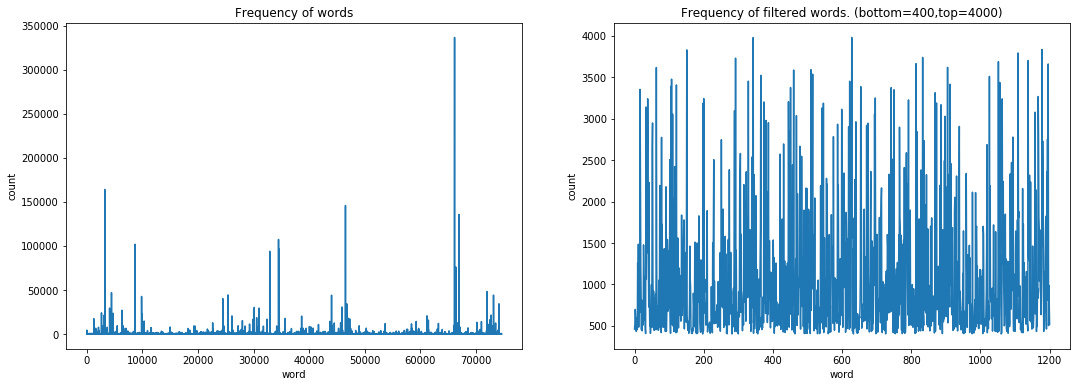

In [263]:
plt.figure(figsize=(18,6))
# figure 1
plt.subplot(1, 2, 1)
plt.plot(counts)
plt.xlabel("word")
plt.ylabel("count")
plt.title("Frequency of words")
print("features", len(counts), "mean", counts.mean(), "median", np.median(counts))

# figure 2
plt.subplot(1, 2, 2)
top = 4000
bottom = 400
counts_filtered_top = counts[counts<top]
counts_filtered = counts_filtered_top[counts_filtered_top>bottom]
print("features", len(counts_filtered), "mean", counts_filtered.mean(), "median", np.median(counts_filtered))
plt.plot(counts_filtered)
plt.xlabel("word")
plt.ylabel("count")
plt.title("Frequency of filtered words. (bottom={},top={})".format(bottom, top))

# possible values for min 3, 50, 100, 400
# possible values for max 400, 4000, 40000

{'whiskers': [<matplotlib.lines.Line2D at 0x1a26256c50>,
 'caps': [<matplotlib.lines.Line2D at 0x1a26247320>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a26256b00>,
 'medians': [<matplotlib.lines.Line2D at 0x1a262479b0>,
 'fliers': [],
 'means': []}

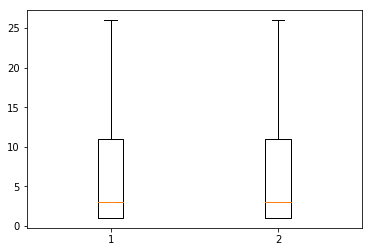

In [264]:
data_counts = [counts, counts_filtered_top]
plt.boxplot(data_counts, showfliers=False)

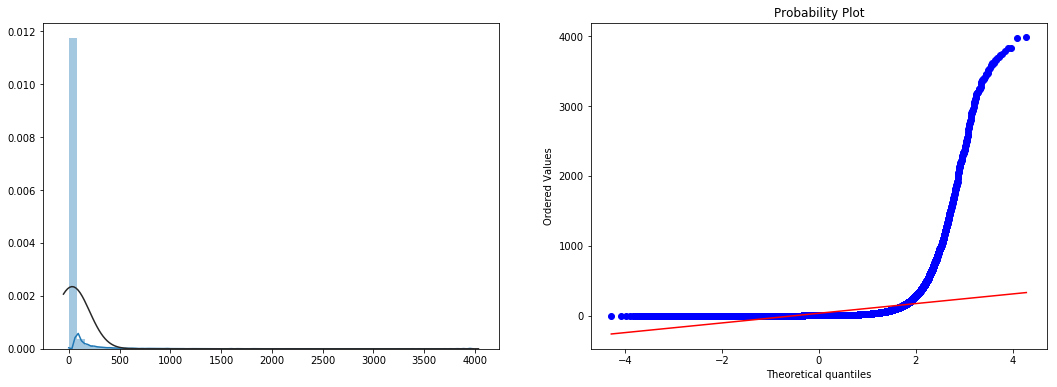

In [268]:
plt.figure(figsize=(18,6))  # follows a normal distribution? 
plt.subplot(1,2,1)

sns.distplot(counts_filtered_top, fit=norm) 
plt.subplot(1,2,2)
res = stats.probplot(counts_filtered_top, plot=plt)

2386 9 227.142


(array([1.000e+00, 1.300e+01, 4.500e+01, 1.690e+02, 4.180e+02, 5.140e+02,
        4.940e+02, 4.580e+02, 4.770e+02, 5.330e+02, 9.590e+02, 1.695e+03,
        1.802e+03, 1.515e+03, 1.326e+03, 1.141e+03, 1.017e+03, 9.060e+02,
        8.040e+02, 6.880e+02, 6.570e+02, 5.450e+02, 5.600e+02, 5.060e+02,
        4.810e+02, 4.260e+02, 3.610e+02, 3.390e+02, 3.390e+02, 3.180e+02,
        3.090e+02, 2.960e+02, 2.420e+02, 2.400e+02, 2.350e+02, 2.530e+02,
        2.140e+02, 1.560e+02, 2.070e+02]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390]),
 <a list of 39 Patch objects>)

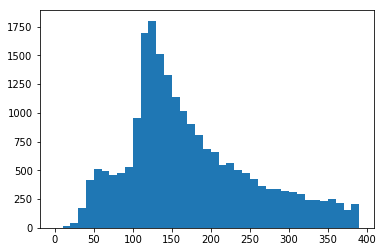

In [426]:
counts_review = np.ravel(data.sum(axis=1))
print(counts_review.max(), counts_review.min(), counts_review.mean())
plt.hist(counts_review, bins = np.arange(0,400,10))

# Feature Engineering & Model Selection

In [3]:
score = 'f1'

## Logistic Regression

Feature engineering considering TF-IDF

In [208]:
parameters_regression_tfidf = {
    'vec__min_df': [3, 50, 100, 400, 1],
    'vec__max_df': [4000, 40000, 1.0],
    'vec__stem': [True, False],
    'vec__ngram_range':[(1, 1), (1, 2), (2, 2)],
    'tfidf__norm': ['l1', 'l2'],
    'tfidf__smooth_idf': [True, False],
    'clf__fit_intercept': [True, False], 
    'clf__C': [.5, 1, 2, 2.5, 3], 
}

pipeline_regression_tfidf = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=False)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(solver='saga', penalty='l2'))
])
                  
rs_regression_tfidf = RandomizedSearchCV(pipeline_regression_tfidf, parameters_regression_tfidf, 
                                   cv=10, scoring=score, n_jobs=-1, verbose=0, random_state=62, n_iter=20, 
                                         return_train_score=True)
start = time.time()
rs_regression_tfidf.fit(X_train, y)
time.time() - start, rs_regression_tfidf.best_params_, rs_regression_tfidf.best_score_

(5251.9633893966675,
 {'vec__stem': False,
  'vec__ngram_range': (1, 2),
  'vec__min_df': 100,
  'vec__max_df': 4000,
  'tfidf__smooth_idf': False,
  'tfidf__norm': 'l2',
  'clf__fit_intercept': False,
  'clf__C': 2.5},
 0.8953462918411281)

In [209]:
pd.DataFrame(rs_regression_tfidf.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vec__stem,param_vec__ngram_range,param_vec__min_df,param_vec__max_df,param_tfidf__smooth_idf,param_tfidf__norm,param_clf__fit_intercept,param_clf__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
14,31.785872,0.286845,1.997381,0.067683,False,"(1, 2)",100,4000,False,l2,False,2.5,"{'vec__stem': False, 'vec__ngram_range': (1, 2...",0.901186,0.906613,0.895817,0.892320,0.894548,0.885635,0.883117,0.903251,0.892332,0.898643,0.895346,0.007052,1,0.948263,0.949046,0.948518,0.948519,0.948216,0.948183,0.949060,0.947201,0.948262,0.948207,0.948348,0.000495
8,252.530001,1.001709,26.464286,0.475152,True,"(2, 2)",3,1,True,l2,True,2.5,"{'vec__stem': True, 'vec__ngram_range': (2, 2)...",0.895924,0.897943,0.881383,0.887658,0.884446,0.891989,0.881064,0.892758,0.895110,0.898447,0.890672,0.006270,2,0.987338,0.988704,0.987783,0.988128,0.987906,0.987913,0.987604,0.987150,0.988095,0.987423,0.987804,0.000430
13,11.857570,0.060254,1.119470,0.017520,False,"(1, 1)",50,40000,False,l2,True,3,"{'vec__stem': False, 'vec__ngram_range': (1, 1...",0.898930,0.894042,0.890205,0.888801,0.887735,0.883353,0.876582,0.886680,0.882797,0.893012,0.888214,0.006058,3,0.934394,0.934399,0.935233,0.935303,0.934011,0.935261,0.934873,0.935120,0.935144,0.934095,0.934783,0.000482
1,235.351550,5.165870,25.773658,0.816844,True,"(1, 1)",50,40000,True,l2,True,3,"{'vec__stem': True, 'vec__ngram_range': (1, 1)...",0.892928,0.889509,0.888976,0.885624,0.884075,0.874162,0.874507,0.886867,0.887569,0.894966,0.885918,0.006548,4,0.926562,0.928436,0.927657,0.928455,0.928174,0.929196,0.930041,0.928278,0.928935,0.926838,0.928257,0.000992
15,32.017736,0.424411,2.087793,0.033162,False,"(1, 2)",100,1,False,l2,False,0.5,"{'vec__stem': False, 'vec__ngram_range': (1, 2...",0.892758,0.896026,0.879086,0.885805,0.887828,0.878416,0.872399,0.888536,0.883241,0.881543,0.884564,0.006732,5,0.909443,0.907923,0.909866,0.909635,0.909555,0.910429,0.909019,0.907810,0.909788,0.908067,0.909153,0.000868
18,227.387620,35.132097,21.169703,7.060336,True,"(1, 2)",400,40000,True,l2,False,1,"{'vec__stem': True, 'vec__ngram_range': (1, 2)...",0.879874,0.881342,0.871614,0.877373,0.875650,0.864715,0.867821,0.881933,0.873849,0.874803,0.874897,0.005368,6,0.895291,0.893376,0.894767,0.894157,0.894333,0.894665,0.895187,0.894739,0.895877,0.894746,0.894714,0.000645
4,31.758895,0.151905,2.151341,0.038139,False,"(1, 2)",50,4000,False,l1,False,3,"{'vec__stem': False, 'vec__ngram_range': (1, 2...",0.873072,0.875693,0.868072,0.868599,0.873317,0.866878,0.857592,0.879365,0.871146,0.868944,0.870268,0.005583,7,0.885394,0.884994,0.885767,0.886080,0.885455,0.884806,0.885861,0.883866,0.884769,0.884162,0.885116,0.000693
16,252.265632,1.684677,26.957509,0.342728,True,"(1, 2)",400,4000,True,l2,False,1,"{'vec__stem': True, 'vec__ngram_range': (1, 2)...",0.874016,0.877221,0.869667,0.864158,0.877543,0.859621,0.859621,0.872713,0.874601,0.873072,0.870223,0.006421,8,0.893104,0.893063,0.894436,0.894980,0.894086,0.894450,0.893813,0.892558,0.894301,0.893376,0.893817,0.000728
3,37.121524,0.353529,2.430551,0.059831,False,"(1, 2)",3,4000,True,l1,True,2.5,"{'vec__stem': False, 'vec__ngram_range': (1, 2...",0.872868,0.874660,0.867101,0.867545,0.876596,0.862822,0.854839,0.876947,0.872671,0.869024,0.869507,0.006505,9,0.892433,0.893998,0.894150,0.893688,0.893267,0.893915,0.893108,0.891587,0.892304,0.892833,0.893128,0.000799
12,25.720951,0.083602,1.559441,0.017758,False,"(2, 2)",50,1,False,l2,False,2,"{'vec__stem': False, 'vec__ngram_range': (2, 2...",0.867460,0.873453,0.859144,0.860649,0.860567,0.8678

Feature engineering BoW

In [210]:
parameters_regression_bow = {
    'vec__min_df': [3, 50, 100, 400, 1],
    'vec__max_df': [400, 4000, 40000, 1.0],
    'vec__stem': [True, False],
    'vec__ngram_range':[(1, 1), (1, 2), (2, 2)],
    'clf__fit_intercept': [True, False], 
    'clf__C': [.5, 1, 2, 2.5, 3], 
}

pipeline_regression_bow = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None)),
    ('clf', LogisticRegression(solver='saga', penalty='l2', max_iter=200))
])
                  
rs_regression_bow = RandomizedSearchCV(pipeline_regression_bow, parameters_regression_bow, 
                                   cv=15, scoring=score, n_jobs=-1, verbose=0, random_state=62, n_iter=20,
                                      return_train_score=True)
start = time.time()
rs_regression_bow.fit(X_train, y)
time.time() - start, rs_regression_bow.best_params_, rs_regression_bow.best_score_

/Users/cuent/anaconda/envs/comp551-proj2/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(9610.997161865234,
 {'vec__stem': False,
  'vec__ngram_range': (1, 2),
  'vec__min_df': 1,
  'vec__max_df': 400,
  'clf__fit_intercept': False,
  'clf__C': 0.5},
 0.9040914014287277)

In [211]:
pd.DataFrame(rs_regression_bow.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vec__stem,param_vec__ngram_range,param_vec__min_df,param_vec__max_df,param_clf__fit_intercept,param_clf__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,mean_train_score,std_train_score
7,150.317218,5.914168,1.549478,0.046928,False,"(1, 2)",1,400,False,0.5,"{'vec__stem': False, 'vec__ngram_range': (1, 2...",0.908218,0.907484,0.903529,0.907046,0.889152,0.918404,0.902728,0.905592,0.903730,0.896469,0.888758,0.905136,0.912552,0.896510,0.916067,0.904091,0.008313,1,0.998199,0.998328,0.999614,0.998114,0.998199,0.997985,0.998027,0.998199,0.997942,0.998242,0.998199,0.998157,0.998242,0.998285,0.998156,0.998259,0.000377
4,305.350994,2.414326,18.169974,0.259414,True,"(1, 2)",3,400,True,0.5,"{'vec__stem': True, 'vec__ngram_range': (1, 2)...",0.901561,0.899822,0.886136,0.899115,0.887972,0.903651,0.894923,0.898325,0.899522,0.895238,0.890468,0.902483,0.909846,0.894484,0.911712,0.898349,0.006956,2,0.996614,0.996956,0.998971,0.996871,0.996058,0.996613,0.996313,0.996527,0.996312,0.996613,0.996742,0.996570,0.996400,0.996870,0.996570,0.996733,0.000641
19,304.270236,36.747755,16.246507,2.493766,True,"(1, 2)",3,1,False,0.5,"{'vec__stem': True, 'vec__ngram_range': (1, 2)...",0.897983,0.895452,0.902031,0.881899,0.884706,0.896552,0.894454,0.888352,0.878951,0.887433,0.879483,0.899584,0.893491,0.890476,0.900000,0.891390,0.007357,3,0.939167,0.939461,0.945124,0.939978,0.939601,0.939974,0.939602,0.939257,0.940207,0.938970,0.939465,0.938558,0.940242,0.939562,0.938836,0.939867,0.001481
9,296.678784,2.133247,17.782592,0.311741,True,"(2, 2)",3,40000,True,2,"{'vec__stem': True, 'vec__ngram_range': (2, 2)...",0.886512,0.881556,0.899170,0.880615,0.882111,0.885324,0.874925,0.881928,0.881965,0.883194,0.872491,0.895147,0.881936,0.884638,0.897638,0.884611,0.007268,4,0.997600,0.997086,0.997172,0.997300,0.998071,0.997043,0.997042,0.997301,0.997515,0.997258,0.997215,0.997300,0.997172,0.997301,0.997214,0.997306,0.000253
5,121.177887,14.089188,1.175479,0.039654,False,"(2, 2)",1,4000,True,0.5,"{'vec__stem': False, 'vec__ngram_range': (2, 2...",0.879290,0.882701,0.893668,0.870337,0.882147,0.884638,0.880526,0.881579,0.876499,0.880995,0.878592,0.895397,0.878538,0.875895,0.892512,0.882221,0.006687,5,0.999057,0.999271,0.999657,0.999100,0.999057,0.999100,0.999271,0.999143,0.999057,0.999057,0.999143,0.999143,0.999272,0.999229,0.999272,0.999189,0.000150
8,262.217608,3.135966,17.414064,0.351692,True,"(1, 1)",3,1,True,3,"{'vec__stem': True, 'vec__ngram_range': (1, 1)...",0.880952,0.891124,0.882601,0.874484,0.880047,0.892985,0.893642,0.870192,0.852184,0.882775,0.872066,0.882562,0.881416,0.877381,0.884198,0.879908,0.009965,6,0.905072,0.904086,0.908658,0.904742,0.904594,0.904632,0.904501,0.904930,0.906285,0.905566,0.905458,0.904432,0.905630,0.905112,0.904034,0.905182,0.001101
0,256.497799,2.358328,17.330120,0.256446,True,"(1, 1)",1,4000,False,2,"{'vec__stem': True, 'vec__ngram_range': (1, 1)...",0.891136,0.889284,0.879290,0.887441,0.869718,0.884410,0.879762,0.866505,0.857992,0.877698,0.857143,0.877872,0.876258,0.869617,0.895522,0.877312,0.011088,7,0.942773,0.942597,0.963045,0.942578,0.942336,0.944243,0.942552,0.942782,0.943366,0.943341,0.943918,0.942868,0.942653,0.944122,0.942517,0.944380,0.005024
10,25.090355,0.428465,0.741297,0.023155,False,"(1, 1)",100,40000,True,1,"{'vec__stem': False, 'vec__ngram_range': (1, 1...",0.882562,0.887307,0.879713,0.871674,0.8752

In [212]:
parameters_regression_bin = {
#     'vec__stem': [True, False],
#     'clf__fit_intercept': [True, False], 
    'clf__C': [.5, 1, 2, 2.5, 3], 
}

pipeline_regression_bin = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=True, max_df=400, min_df=3,
                                ngram_range=(1,2), stem=True)),
    ('clf', LogisticRegression(solver='saga', penalty='l2', fit_intercept=True, max_iter=1000))
])
                  
rs_regression_bin = GridSearchCV(pipeline_regression_bin, parameters_regression_bin, 
                                   cv=15, scoring=score, n_jobs=-1, verbose=0, return_train_score=True)
                            #, random_state=62, n_iter=20)
start = time.time()
rs_regression_bin.fit(X_train, y)
time.time() - start, rs_regression_bin.best_params_, rs_regression_bin.best_score_

(6781.202300071716, {'clf__C': 0.5}, 0.8958046812134007)

In [213]:
pd.DataFrame(rs_regression_bin.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,mean_train_score,std_train_score
0,361.707683,5.105309,18.154699,0.469170,0.5,{'clf__C': 0.5},0.904648,0.899353,0.889801,0.897527,0.882701,0.897421,0.898516,0.895021,0.888889,0.893007,0.890215,0.897343,0.902007,0.896552,0.904077,0.895805,0.005825,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,402.473715,8.110607,18.290383,0.515732,1,{'clf__C': 1},0.905301,0.902007,0.891101,0.897647,0.883225,0.898082,0.894299,0.896345,0.889022,0.890746,0.888358,0.896426,0.900826,0.895468,0.902102,0.895397,0.005832,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,457.334456,11.801718,18.518091,0.374315,2.5,{'clf__C': 2.5},0.904224,0.903721,0.889930,0.895698,0.882423,0.896882,0.894580,0.896345,0.889556,0.889952,0.889021,0.897514,0.900059,0.894260,0.898376,0.894836,0.005690,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,446.756659,13.720502,18.276270,0.426953,2,{'clf__C': 2},0.905301,0.901891,0.890451,0.894768,0.883225,0.897543,0.893516,0.895397,0.889022,0.889952,0.888358,0.897514,0.901891,0.894260,0.899038,0.894809,0.005759,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,423.694898,90.241086,16.276376,4.121535,3,{'clf__C': 3},0.904762,0.901359,0.890579,0.895698,0.882423,0.898082,0.893389,0.897421,0.887155,0.889952,0.889021,0.898058,0.898876,0.893591,0.896510,0.894459,0.005652,5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


## Multinomial Naive Bayes

Feature engineering considering BoW

In [214]:
parameters_mnv_bow = {
    'vec__min_df': [3, 50, 100, 400, 1],
    'vec__max_df': [4000, 40000, 1.0],
    'vec__stem': [True, False],
    'vec__ngram_range':[(1, 2), (2, 2)],
    'clf__alpha': [.5, .1, 2, 3], 
}

pipeline_mnv_bow = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=False)),
    ('clf', MultinomialNB())
])
                  
rs_mnv_bow = RandomizedSearchCV(pipeline_mnv_bow, parameters_mnv_bow, 
                                   cv=15, scoring=score, n_jobs=-1, verbose=0, random_state=62, n_iter=20
                               , return_train_score=True)
start = time.time()
rs_mnv_bow.fit(X_train, y)
time.time() - start, rs_mnv_bow.best_params_, rs_mnv_bow.best_score_

(19414.725648880005,
 {'vec__stem': False,
  'vec__ngram_range': (2, 2),
  'vec__min_df': 1,
  'vec__max_df': 1.0,
  'clf__alpha': 2},
 0.8875362305239204)

In [215]:
pd.DataFrame(rs_mnv_bow.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vec__stem,param_vec__ngram_range,param_vec__min_df,param_vec__max_df,param_clf__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,split12_train_score,split13_train_score,split14_train_score,mean_train_score,std_train_score
11,27.338482,0.264187,1.195799,0.035670,False,"(2, 2)",1,1,2,"{'vec__stem': False, 'vec__ngram_range': (2, 2...",0.879511,0.900480,0.899094,0.883273,0.889831,0.888485,0.894231,0.893513,0.874156,0.879569,0.871299,0.889851,0.894417,0.889831,0.885487,0.887536,0.008322,1,0.994407,0.994103,0.994192,0.993845,0.994320,0.993931,0.993497,0.994017,0.993844,0.993931,0.993844,0.993628,0.993585,0.994105,0.993973,0.993948,0.000249
0,256.710281,2.887174,17.397306,0.407629,True,"(2, 2)",1,1,2,"{'vec__stem': True, 'vec__ngram_range': (2, 2)...",0.879708,0.894387,0.901391,0.879663,0.886623,0.888214,0.894103,0.886978,0.878287,0.871703,0.869565,0.892175,0.895181,0.885801,0.886598,0.886026,0.008624,2,0.990813,0.990985,0.991289,0.990727,0.990725,0.990857,0.990682,0.990724,0.990813,0.990594,0.990724,0.990901,0.990725,0.990987,0.990684,0.990815,0.000167
5,33.380934,0.351356,1.609731,0.032869,False,"(1, 2)",1,4000,3,"{'vec__stem': False, 'vec__ngram_range': (1, 2...",0.877724,0.897619,0.898082,0.883582,0.886499,0.882424,0.894358,0.892683,0.872881,0.870968,0.870813,0.883436,0.893848,0.880866,0.890909,0.885114,0.009012,3,0.979375,0.979666,0.979627,0.979459,0.979678,0.979325,0.979219,0.979449,0.979458,0.979235,0.979654,0.979410,0.979263,0.979719,0.978902,0.979429,0.000215
17,265.768027,9.286911,768.698651,1913.983053,True,"(2, 2)",3,1,0.1,"{'vec__stem': True, 'vec__ngram_range': (2, 2)...",0.879081,0.896716,0.890877,0.877551,0.881618,0.884988,0.882775,0.887668,0.882675,0.866469,0.868516,0.888889,0.897129,0.885009,0.878460,0.883229,0.008423,4,0.982700,0.982733,0.982449,0.982185,0.982060,0.982231,0.982394,0.981748,0.982399,0.981300,0.982789,0.982533,0.981712,0.982362,0.982228,0.982255,0.000399
1,33.303984,0.316284,1.598839,0.052621,False,"(1, 2)",1,40000,0.5,"{'vec__stem': False, 'vec__ngram_range': (1, 2...",0.875000,0.893617,0.894833,0.879854,0.885662,0.877839,0.888082,0.885609,0.868389,0.863388,0.862674,0.877085,0.891743,0.876144,0.877538,0.879833,0.009804,5,0.995441,0.995743,0.995527,0.995570,0.995571,0.995311,0.995440,0.995527,0.995441,0.995225,0.995829,0.995484,0.995440,0.995528,0.995398,0.995498,0.000145
15,262.922652,1.083385,17.752333,0.420279,True,"(1, 2)",3,1,0.5,"{'vec__stem': True, 'vec__ngram_range': (1, 2)...",0.870416,0.887009,0.889697,0.871981,0.880435,0.875921,0.880823,0.880835,0.858716,0.856799,0.863005,0.877388,0.886336,0.874543,0.876144,0.875338,0.009532,6,0.953661,0.953838,0.953813,0.952546,0.953447,0.953566,0.953534,0.952996,0.953617,0.953166,0.953954,0.953371,0.952840,0.954670,0.953479,0.953500,0.000487
14,264.902432,0.850924,17.942699,0.342192,True,"(1, 2)",1,40000,3,"{'vec__stem': True, 'vec__ngram_range': (1, 2)...",0.867764,0.881785,0.886473,0.869148,0.879518,0.873394,0.883023,0.877689,0.861314,0.856802,0.859892,0.875616,0.882850,0.876812,0.870146,0.873483,0.008793,7,0.967574,0.968639,0.968081,0.967355,0.968305,0.967187,0.967574,0.967661,0.968036,0.967862,0.967585,0.968347,0.967001,0.968249,0.967347,0.967787,0.000460
13,31.445339,0.172708,1.521602,0.033771,False,"(1, 2)",3,1,2,"{'vec__stem': False, 'vec__ngram_range': (1, 2...",0.864167,0.885385,0.881995,0.873341,0.873716,0.874539,0.885784,0.877601,0.861709,0.856451,0.855407,0.868159,0.88303

## Bernoulli Naive Bayes

Feature engineering, binary values

In [18]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

In [67]:
params_bnv = {
    'clf__smooth': uniform(0,2)
}

bnv = vect = LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=True, 
                                stem=True, ngram_range=(1, 2), min_df=250, max_df=4000, preprocessing=True)
X_train_bnv = bnv.fit_transform(X_train)

pipeline_bnv = Pipeline([
    ('clf', BernoulliNaiveBayes())
])

gs_bnv = RandomizedSearchCV(pipeline_bnv, params_bnv, 
                                   cv=10, scoring=score, verbose=0, return_train_score=True)
start = time.time()
gs_bnv.fit(X_train_bnv.toarray(), y)

# scores = cross_val_score(bnv_clf, X_train_vect.toarray(), y, cv=20, scoring='f1', n_jobs=-1)
# time.time() - start, scores, scores.mean(), scores.std()
time.time() - start, gs_bnv.best_params_, gs_bnv.best_score_

(485.6470880508423, {'clf__smooth': 0.07653511447789829}, 0.8528520285195769)

In [68]:
pd.DataFrame(gs_bnv.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__smooth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,3.232343,0.059794,0.100694,0.004363,0.0765351,{'clf__smooth': 0.07653511447789829},0.862500,0.859628,0.853375,0.850119,...,0.860644,0.861239,0.861396,0.859468,0.861672,0.861179,0.860748,0.861650,0.860863,0.000670
4,3.128640,0.026545,0.095614,0.000912,0.33695,{'clf__smooth': 0.3369503010062169},0.862500,0.859628,0.853375,0.850119,...,0.860594,0.861152,0.861309,0.859506,0.861672,0.861141,0.860848,0.861699,0.860846,0.000662
5,3.109517,0.025445,0.097078,0.002044,0.343728,{'clf__smooth': 0.34372788670152166},0.862500,0.859628,0.853375,0.850119,...,0.860594,0.861152,0.861309,0.859506,0.861672,0.861141,0.860848,0.861699,0.860846,0.000662
6,3.130950,0.035579,0.097852,0.002570,0.205979,{'clf__smooth': 0.20597933983692807},0.862500,0.859628,0.853375,0.850119,...,0.860644,0.861202,0.861309,0.859468,0.861672,0.861179,0.860848,0.861650,0.860851,0.000666
1,3.165793,0.083789,0.097643,0.002877,0.542786,{'clf__smooth': 0.5427860801725255},0.862500,0.859628,0.853375,0.850119,...,0.860556,0.861339,0.861284,0.859555,0.861646,0.861141,0.860860,0.861699,0.860858,0.000668
9,3.130206,0.028252,0.096907,0.001243,0.513698,{'clf__smooth': 0.5136977116067787},0.862500,0.859628,0.853375,0.850119,...,0.860556,0.861252,0.861284,0.859555,0.861646,0.861141,0.860860,0.861699,0.860844,0.000665
7,3.123743,0.030240,0.097057,0.001695,0.99687,{'clf__smooth': 0.9968695443754341},0.861827,0.859628,0.853375,0.850119,...,0.860606,0.861276,0.861334,0.859617,0.861696,0.861153,0.860785,0.861624,0.860858,0.000654
8,3.130850,0.031603,0.097292,0.001526,0.975939,{'clf__smooth': 0.9759385602089541},0.861827,0.859628,0.853375,0.850119,...,0.860606,0.861313,0.861334,0.859617,0.861696,0.861153,0.860785,0.861624,0.860861,0.000657
2,3.226222,0.097866,0.103614,0.018131,1.24639,{'clf__smooth': 1.2463857325411893},0.861827,0.859628,0.853044,0.849663,...,0.860531,0.861288,0.861383,0.859629,0.861646,0.861078,0.860759,0.861624,0.860838,0.000657
3,3.118246,0.038577,0.098309,0.002291,1.24479,{'clf__smooth': 1.2447870787653956},0.861827,0.859628,0.853044,0.849663,...,0.860531,0.861288,0.861383,0.859629,0.861646,0.861078,0.860759,0.861624,0.860838,0.000657


## Decision Tree

In [512]:
parameters_tree = {
    'vec__min_df': [3, 50, 100, 400],
    'vec__max_df': [4000, 40000],
    'vec__stem': [True],
    'vec__ngram_range':[(1, 2), (2, 2)],
    'clf__max_depth': [300, 500, 700],
    'clf__min_samples_split': [1, 2, 5],
    'clf__min_samples_leaf': [1, 2, 5]
}

pipeline_tree = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=False)),
    ('clf', DecisionTreeClassifier())
])
                  
rs_tree = RandomizedSearchCV(pipeline_tree, parameters_tree, 
                                   cv=10, scoring=score, n_jobs=-1, verbose=0, random_state=62, n_iter=1
                               , return_train_score=True)
start = time.time()
rs_tree.fit(X_train, y)

time.time() - start, rs_tree.best_params_, rs_tree.best_score_

(1134.332978963852,
 {'vec__stem': True,
  'vec__ngram_range': (1, 2),
  'vec__min_df': 50,
  'vec__max_df': 4000,
  'clf__min_samples_split': 2,
  'clf__min_samples_leaf': 1,
  'clf__max_depth': 300},
 0.7072313256744643)

## Support Vector Machine

In [216]:
parameters_svm = {
    'clf__degree': [2, 3, 4], 
    'clf__C': [.5, 1.0, 2.5, 3], 
}

pipeline_svm = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, ngram_range=(1,2), 
                                 min_df=3, max_df=400, stem=True, binary=False)),
    ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True,)),
    ('clf', SVC())
])
                  
rs_svm = RandomizedSearchCV(pipeline_svm, parameters_svm, cv=2, scoring=score, n_jobs=-1, 
                            verbose=1000, random_state=62, n_iter=2, return_train_score=True)
start = time.time()
rs_svm.fit(X_train, y)
time.time() - start, rs_svm.best_params_, rs_svm.best_score_

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Pickling array (shape=(25000,), dtype=object).
Pickling array (shape=(25000,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
Pickling array (shape=(25000,), dtype=object).
Pickling array (shape=(25000,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
Pickling array (shape=(25000,), dtype=object).
Pickling array (shape=(25000,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
Pickling array (shape=(25000,), dtype=object).
Pickling array (shape=(25000,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed: 15.2min r

/Users/cuent/anaconda/envs/comp551-proj2/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(1747.760658979416, {'clf__degree': 3, 'clf__C': 2.5}, 0.8262288670868729)

#### Linear SVC

In [273]:
parameters_linearsvm = {
#     'clf__degree': [2, 3, 4], 
#     'clf__C': [.5, 1.0, 2.5, 3], 
}

pipeline_linearsvm = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, ngram_range=(1,2), 
                                 min_df=5, max_df=.8, stem=True, binary=False, preprocessing=True)),
    ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=True, use_idf=True)),
    ('clf', LinearSVC())
])
                  
rs_linearsvm = GridSearchCV(pipeline_linearsvm, parameters_linearsvm, 
                                   cv=2, scoring=score, n_jobs=-1, verbose=1000, 
                                         return_train_score=True)
start = time.time()
rs_linearsvm.fit(X_train, y)
time.time() - start, rs_linearsvm.best_params_, rs_linearsvm.best_score_

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Pickling array (shape=(25000,), dtype=object).
Pickling array (shape=(25000,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
Pickling array (shape=(25000,), dtype=object).
Pickling array (shape=(25000,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
Pickling array (shape=(12500,), dtype=int64).
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  3.1min finished


(310.9432089328766, {}, 0.8958614175826981)

## NBSVM

In [270]:
from scipy.stats import uniform

parameters_nbsvm = {
    'vect__ngram_range': [(1,2), (1,3)],
    'vect__min_df': [2],
    'vect__max_df': [1.0],
    'clf__beta': uniform(0,1),
    'clf__alpha': uniform(.5,1),
    'clf__C': uniform(30, 40)
}
pipeline_nbsvm = Pipeline([
    ('vect', LemmaCountVectorizer(strip_accents='unicode', stop_words=None,stem=False, preprocessing=True)),
    ('clf', NBSVM())
])

gs_nbsvm = RandomizedSearchCV(pipeline_nbsvm, parameters_nbsvm, 
                                   cv=10, scoring=score, n_jobs=-1, verbose=3,
                                 return_train_score=True, n_iter=20, random_state=62)
start = time.time()
gs_nbsvm.fit(X_train, y)
time.time()-start, gs_nbsvm.best_params_, gs_nbsvm.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 55.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 97.8min finished


(5935.145317077637,
 {'clf__C': 63.31041288467941,
  'clf__alpha': 0.6492837008604102,
  'clf__beta': 0.2736639871258223,
  'vect__max_df': 1.0,
  'vect__min_df': 2,
  'vect__ngram_range': (1, 3)},
 0.9164024781200871)

In [271]:
pd.DataFrame(gs_nbsvm.cv_results_).sort_values(by=['mean_test_score'], ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__alpha,param_clf__beta,param_vect__max_df,param_vect__min_df,param_vect__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
7,108.174109,12.945563,5.019913,0.303700,63.3104,0.649284,0.273664,1,2,"(1, 3)","{'clf__C': 63.31041288467941, 'clf__alpha': 0....",0.920143,0.918424,0.913541,0.915970,0.919284,0.915470,0.898024,0.921304,0.921053,0.920812,0.916402,0.006622,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999956,0.999956,1.000000,1.000000,0.999991,0.000018
1,238.186817,55.525326,5.649907,0.250644,58.365,1.38641,0.282825,1,2,"(1, 3)","{'clf__C': 58.36497474652987, 'clf__alpha': 1....",0.920382,0.918660,0.916996,0.913511,0.920080,0.911706,0.896361,0.919952,0.922524,0.922280,0.916245,0.007425,2,0.999822,0.999822,0.999956,0.999911,0.999911,0.999911,0.999822,0.999956,0.999867,0.999911,0.999889,0.000050
12,180.406100,52.394044,5.466442,0.374667,41.295,0.791467,0.51763,1,2,"(1, 3)","{'clf__C': 41.29497015311559, 'clf__alpha': 0....",0.918940,0.916899,0.912667,0.918359,0.915079,0.909163,0.905138,0.918489,0.919952,0.921856,0.915654,0.004966,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,109.667099,12.395941,5.154001,0.241083,58.8777,0.910497,0.20378,1,2,"(1, 3)","{'clf__C': 58.877698434633004, 'clf__alpha': 0...",0.919091,0.917131,0.911024,0.912714,0.920572,0.914698,0.898734,0.919824,0.921116,0.920749,0.915565,0.006546,4,0.999778,0.999778,0.999867,0.999778,0.999822,0.999822,0.999778,0.999822,0.999778,0.999778,0.999800,0.000030
14,168.066260,40.028676,3.945833,0.183873,63.9887,0.863862,0.335656,1,2,"(1, 2)","{'clf__C': 63.988721188429295, 'clf__alpha': 0...",0.919284,0.918229,0.913718,0.919760,0.917263,0.914902,0.899046,0.910621,0.923016,0.918465,0.915431,0.006374,5,0.999778,0.999733,0.999822,0.999689,0.999778,0.999733,0.999733,0.999778,0.999778,0.999733,0.999756,0.000036
13,230.771548,49.179394,4.138723,0.116819,33.5631,0.636795,0.297257,1,2,"(1, 2)","{'clf__C': 33.563094208219184, 'clf__alpha': 0...",0.917994,0.917431,0.913199,0.917497,0.915903,0.916733,0.898769,0.912435,0.920495,0.917666,0.914812,0.005789,6,0.999644,0.999689,0.999822,0.999689,0.999733,0.999689,0.999733,0.999644,0.999689,0.999689,0.999702,0.000049
19,209.410699,64.977677,5.086894,2.194887,37.1676,0.837202,0.718023,1,2,"(1, 3)","{'clf__C': 37.1675929931015, 'clf__alpha': 0.8...",0.916338,0.915173,0.911742,0.917395,0.915012,0.906709,0.904988,0.917395,0.919841,0.919048,0.914364,0.004782,7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
15,224.179084,34.102164,5.724685,0.949904,49.541,1.29761,0.627411,1,2,"(1, 3)","{'clf__C': 49.54097085416407, 'clf__alpha': 1....",0.916996,0.916468,0.911811,0.915241,0.915903,0.907069,0.904196,0.915605,0.919586,0.919841,0.914272,0.004861,8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,206.606502,44.275841,5.701531,0.628311,65.5653,1.46278,0.611175,1,2,"(1, 3)","{'clf__C': 65.56528254738022, 'clf__alpha': 1....",0.917852,0.916468,0.912598,0.915173,0.916633,0.905990,0.904120,0.914877,0.919778,0.919048,0.914254,0.005020,9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
16,104.990756,13.371900,5.066596,0.270805,57.1893,0.517834,0.800053,1,2,"(1, 3)","{'clf__C': 57.1893234573495, 'clf__alpha': 0.5...",0.917489,0.915241,0.913249,0.916766,0.913286,0.905121,0.902487,0.916799,0.916436,0.919841,0.9136

### Logistic Regression 
Search max_df, percentage

In [285]:
parameters_best_lr = {
    'vec__min_df': [2],
    'vec__max_df': [.9],
    'clf__C': [35], 
}

pipeline_best_lr = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, min_df=3, 
                                 stem=False, ngram_range=(1, 2), preprocessing=True, )),
        ('tfidf', TfidfTransformer(use_idf=1,smooth_idf=1,sublinear_tf=1)),
    ('clf', LogisticRegression(solver='saga', penalty='l2', max_iter=40000, tol=0.0001, fit_intercept=True))
])
                  
rs_lr_max_per = GridSearchCV(pipeline_best_lr, parameters_best_lr, 
                                   cv=5, scoring=score, n_jobs=-1, verbose=0,
                                      return_train_score=True)

start = time.time()
rs_lr_max_per.fit(X_train, y)
time.time() - start, rs_lr_max_per.best_params_, rs_lr_max_per.best_score_

(129.82043886184692,
 {'clf__C': 35, 'vec__max_df': 0.9, 'vec__min_df': 2},
 0.9084344418346936)

### Logistic Regression 
Search max_df, fixed value

In [207]:
parameters_best_lr = {
    'vec__min_df': [2],
    'vec__max_df': [4400],
    'clf__C': [35], 
}

pipeline_best_lr = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, 
                                 stem=False, ngram_range=(1, 2), preprocessing=True, )),
        ('tfidf', TfidfTransformer(use_idf=1,smooth_idf=1,sublinear_tf=1)),
    ('clf', LogisticRegression(solver='saga', penalty='l2', max_iter=40000, tol=0.0001, fit_intercept=True))
])
                  
rs_best_lr = GridSearchCV(pipeline_best_lr, parameters_best_lr, 
                                   cv=80, scoring=['f1', 'precision', 'recall'], n_jobs=-1, verbose=0,
                                      return_train_score=True, refit='f1')

start = time.time()
rs_best_lr.fit(X_train, y)
time.time() - start, rs_best_lr.best_params_, rs_best_lr.best_score_

(2582.644148349762,
 {'clf__C': 35, 'vec__max_df': 4400, 'vec__min_df': 2},
 0.9136939635528595)

In [284]:
parameters_best_lr = {
    'vec__min_df': [2],
    'vec__max_df': [4400],
    'clf__C': uniform(30,40), 
}

pipeline_best_lr = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, 
                                 stem=False, ngram_range=(1, 2), preprocessing=True, )),
        ('tfidf', TfidfTransformer(use_idf=1,smooth_idf=1,sublinear_tf=1)),
    ('clf', LogisticRegression(solver='saga', penalty='l2', max_iter=40000, tol=0.0001, fit_intercept=True))
])
                  
rs_best_lr3 = RandomizedSearchCV(pipeline_best_lr, parameters_best_lr, 
                                   cv=5, scoring=['f1', 'precision', 'recall'], n_jobs=-1, verbose=0,
                                      return_train_score=True, refit='f1')

start = time.time()
rs_best_lr3.fit(X_train, y)
time.time() - start, rs_best_lr3.best_params_, rs_best_lr3.best_score_

(1395.5862810611725,
 {'clf__C': 68.35390244026648, 'vec__max_df': 4400, 'vec__min_df': 2},
 0.9095024019634056)

### Logistic regression
Try normalizing

In [283]:
from sklearn.preprocessing import RobustScaler

parameters_best_lr = {
    'vec__min_df': [2],
    'vec__max_df': [44000],
    'clf__C': [1], 
}

pipeline_best_lr = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, 
                                 stem=False, ngram_range=(2, 2), preprocessing=True, )),
        ('tfidf', TfidfTransformer(use_idf=1,smooth_idf=1,sublinear_tf=1)),
    ('scale', RobustScaler(with_centering=False)),
    ('clf', LogisticRegression(solver='saga', penalty='l2', max_iter=40000, tol=0.0001, fit_intercept=True))
])
                  
rs_lr_scaler = GridSearchCV(pipeline_best_lr, parameters_best_lr, 
                                   cv=2, scoring=['f1', 'precision', 'recall'], n_jobs=-1, verbose=0,
                                      return_train_score=True, refit='f1')

start = time.time()
rs_lr_scaler.fit(X_train, y)
time.time() - start, rs_lr_scaler.best_params_, rs_lr_scaler.best_score_

(242.97897291183472,
 {'clf__C': 1, 'vec__max_df': 44000, 'vec__min_df': 2},
 0.8529732208900852)

### Logistic regression
Only counts

In [292]:
parameters_best_lr2 = {
    'vec__min_df': [2],
    'vec__max_df': [4400],
    'clf__C': [35], 
}

pipeline_best_lr = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words=None, 
                                 stem=False, ngram_range=(1, 2), preprocessing=True, )),
    ('clf', LogisticRegression(solver='saga', penalty='l2', max_iter=40000, tol=0.0001, fit_intercept=True))
])
                  
rs_lr_notf = GridSearchCV(pipeline_best_lr, parameters_best_lr, 
                                   cv=5, scoring=['f1', 'precision', 'recall'], n_jobs=-1, verbose=0,
                                      return_train_score=True, refit='f1')

start = time.time()
rs_lr_notf.fit(X_train, y)
time.time() - start, rs_lr_notf.best_params_, rs_lr_notf.best_score_

(1160.9041471481323,
 {'clf__C': 35, 'vec__max_df': 0.9, 'vec__min_df': 2},
 0.8967622744752337)

### MNB 
Try with tfidf

In [282]:
parameters_best_lr = {
    'vec__min_df': [2],
    'vec__max_df': [4400],
    'clf__alpha': [0.01], 
}

pipeline_best_lr = Pipeline([
    ('vec', LemmaCountVectorizer(strip_accents='unicode', stop_words='english', 
                                 stem=False, ngram_range=(1, 2), preprocessing=True, )),
        ('tfidf', TfidfTransformer(use_idf=1,smooth_idf=1,sublinear_tf=1)),
     ('clf', MultinomialNB())
])
                  
rs_mnb_fix = GridSearchCV(pipeline_best_lr, parameters_best_lr, 
                                   cv=5, scoring=['f1', 'precision', 'recall'], n_jobs=-1, verbose=0,
                                      return_train_score=True, refit='f1')

start = time.time()
rs_mnb_fix.fit(X_train, y)
time.time() - start, rs_mnb_fix.best_params_, rs_mnb_fix.best_score_

(109.62222814559937,
 {'clf__alpha': 0.01, 'vec__max_df': 4400, 'vec__min_df': 2},
 0.8719168762788287)

### MI and best model
#### build vocabulary

no stop words, 50%, no steamming

In [243]:
counter = LemmaCountVectorizer(strip_accents='unicode', stop_words=None,stem=False, ngram_range=(1, 2), 
                                  preprocessing=True, max_df=1.0, min_df=1)

In [147]:
from sklearn.feature_selection import mutual_info_classif

percentage = 50

vect = counter
# LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=False, max_df=1.0, min_df=1)
print("Vectorizing...")
counts = vect.fit_transform(X_train)
print("Getting best tMI indexes...")
mutual_info_idx = np.argsort(-mutual_info_classif(counts, y))

print("Buiding vocabulary...")
top = int((mutual_info_idx.shape[0] * percentage) / 100)
# top = 10 
vocab_all = vect.get_feature_names()
top_idx = mutual_info_idx[:top]
vocabulary = np.take(vocab_all, top_idx)

Vectorizing...
Getting MI...
Buiding vocabulary...


In [244]:
counter.set_params(vocabulary=vocabulary)

LemmaCountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 2), preprocessing=True, preprocessor=None,
           stem=False, stop_words=None, strip_accents='unicode',
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
           vocabulary=array(['bad', 'worst', ..., 'splash certainly', 'splash but'],
      dtype='<U88'))

no stop words, 40%, steamming

In [171]:
counter1 = LemmaCountVectorizer(strip_accents='unicode', stop_words=None,stem=True, ngram_range=(1, 2), 
                                  preprocessing=True, max_df=1.0, min_df=1)

percentage1 = 40

vect1 = counter1
# LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=False, max_df=1.0, min_df=1)
print("Vectorizing...")
counts1 = vect1.fit_transform(X_train)
print("Getting best tMI indexes...")
mutual_info_idx1 = np.argsort(-mutual_info_classif(counts1, y))

print("Buiding vocabulary...")
top1 = int((mutual_info_idx1.shape[0] * percentage1) / 100)
# top = 10 
vocab_all1 = vect1.get_feature_names()
top_idx1 = mutual_info_idx1[:top1]
vocabulary1 = np.take(vocab_all1, top_idx1)

Vectorizing...
Getting best tMI indexes...
Buiding vocabulary...


In [245]:
counter1.set_params(vocabulary=vocabulary1)

LemmaCountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 2), preprocessing=True, preprocessor=None,
           stem=True, stop_words=None, strip_accents='unicode',
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
           vocabulary=array(['bad', 'worst', ..., 'wall will', 'wall william'], dtype='<U88'))

no stop words, 80%, steamming

In [247]:
counter80 = LemmaCountVectorizer(strip_accents='unicode', stop_words=None,stem=False, ngram_range=(1, 2), 
                                  preprocessing=True, max_df=1.0, min_df=1)

percentage80 = 80

vect80 = counter80
# LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=False, max_df=1.0, min_df=1)
print("Vectorizing...")
counts80 = vect80.fit_transform(X_train)
print("Getting best tMI indexes...")
mutual_info_idx80 = np.argsort(-mutual_info_classif(counts80, y))

print("Buiding vocabulary...")
top80 = int((mutual_info_idx80.shape[0] * percentage80) / 100)
# top = 10 
vocab_all80 = vect80.get_feature_names()
top_idx80 = mutual_info_idx80[:top80]
vocabulary80 = np.take(vocab_all80, top_idx80)

Vectorizing...
Getting best tMI indexes...
Buiding vocabulary...


In [248]:
counter80.set_params(vocabulary=vocabulary80)

LemmaCountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 2), preprocessing=True, preprocessor=None,
           stem=False, stop_words=None, strip_accents='unicode',
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
           vocabulary=array(['bad', 'worst', ..., 'grandfatherly skill', 'andrei tarkovky'],
      dtype='<U88'))

#### best model with counts

In [249]:
parameters_nbsvm = {
}
pipeline_nbsvm = Pipeline([
    ('vect', counter),
    ('clf', NBSVM(C=41.29497015311559, alpha=0.7914671389502778, beta=0.5176297089108057))
])

gs_nbsvm_best_count = RandomizedSearchCV(pipeline_nbsvm, parameters_nbsvm, 
                                   cv=5, scoring=score, n_jobs=-1, verbose=3,
                                 return_train_score=True, n_iter=20, random_state=62)
start = time.time()
gs_nbsvm_best_count.fit(X_train, y)
time.time()-start, gs_nbsvm_best_count.best_params_, gs_nbsvm_best_count.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/cuent/anaconda/envs/comp551-proj2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.3min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished


(246.3034553527832, {}, 0.9228923536177926)

In [253]:
parameters_nbsvm = {
}
pipeline_nbsvm1 = Pipeline([
    ('vect', counter1),
    ('clf', NBSVM(C=41.29497015311559, alpha=0.7914671389502778, beta=0.5176297089108057))
])

gs_nbsvm_count_40 = RandomizedSearchCV(pipeline_nbsvm1, parameters_nbsvm, 
                                   cv=5, scoring=score, n_jobs=-1, verbose=3,
                                 return_train_score=True, n_iter=20, random_state=62)
start = time.time()
gs_nbsvm_count_40.fit(X_train, y)
time.time()-start, gs_nbsvm_count_40.best_params_, gs_nbsvm_count_40.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/cuent/anaconda/envs/comp551-proj2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.3min remaining: 10.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.8min finished


(662.469446182251, {}, 0.920845066179548)

#### best model with tfidf

In [272]:
parameters_nbsvm = {
}
pipeline_nbsvm = Pipeline([
    ('vect', counter),
    ('tfidf', TfidfTransformer(use_idf=1,smooth_idf=1,sublinear_tf=1)),
    ('clf', NBSVM(C=41.29497015311559, alpha=0.7914671389502778, beta=0.5176297089108057))
])

gs_nbsvm_tf_vocab = RandomizedSearchCV(pipeline_nbsvm, parameters_nbsvm, 
                                   cv=5, scoring=score, n_jobs=-1, verbose=3,
                                 return_train_score=True, n_iter=20, random_state=62)
start = time.time()
gs_nbsvm_tf_vocab.fit(X_train, y)
time.time()-start, gs_nbsvm_tf_vocab.best_params_, gs_nbsvm_tf_vocab.best_score_

/Users/cuent/anaconda/envs/comp551-proj2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   49.0s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.6s finished


(73.76267528533936, {}, 0.9171623398613418)

####  best logistic regression with vocab

In [241]:
counter

LemmaCountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=None, min_df=1,
           ngram_range=(1, 2), preprocessing=True, preprocessor=None,
           stem=False, stop_words=None, strip_accents='unicode',
           token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
           vocabulary=array(['bad', 'worst', ..., 'splash certainly', 'splash but'],
      dtype='<U88'))

In [261]:
pipeline_best_lr = Pipeline([
    ('vec', counter),
    ('tfidf', TfidfTransformer(use_idf=1, smooth_idf=1, sublinear_tf=1)),
    ('clf', LogisticRegression(solver='saga', penalty='l2', max_iter=40000, tol=0.0001, fit_intercept=True)
)])
                  
gs_lr1_vocab = GridSearchCV(pipeline_best_lr, {}, 
                                   cv=5, scoring=score, n_jobs=-1, verbose=0,
                                      return_train_score=True)

start = time.time()
gs_lr1_vocab.fit(X_train, y)
time.time() - start, gs_lr1_vocab.best_params_, gs_lr1_vocab.best_score_

(102.08423566818237, {}, 0.9036950733860422)

In [171]:
counter1 = LemmaCountVectorizer(strip_accents='unicode', stop_words=None,stem=True, ngram_range=(1, 2), 
                                  preprocessing=True, max_df=1.0, min_df=1)

percentage1 = 40

vect1 = counter1
# LemmaCountVectorizer(strip_accents='unicode', stop_words=None, binary=False, max_df=1.0, min_df=1)
print("Vectorizing...")
counts1 = vect1.fit_transform(X_train)
print("Getting best tMI indexes...")
mutual_info_idx1 = np.argsort(-mutual_info_classif(counts1, y))

print("Buiding vocabulary...")
top1 = int((mutual_info_idx1.shape[0] * percentage1) / 100)
# top = 10 
vocab_all1 = vect1.get_feature_names()
top_idx1 = mutual_info_idx1[:top1]
vocabulary1 = np.take(vocab_all1, top_idx1)

Vectorizing...
Getting best tMI indexes...
Buiding vocabulary...


#### best nbsvm top 80

In [300]:
pipeline_nbsvm = Pipeline([
    ('vect', counter80),
    ('clf', NBSVM(C=41.29497015311559, alpha=0.7914671389502778, beta=0.5176297089108057))
])

gs_nbsvm_count_80 = RandomizedSearchCV(pipeline_nbsvm, {}, 
                                   cv=5, scoring=score, n_jobs=-1, verbose=3,
                                 return_train_score=True, n_iter=20, random_state=62)
start = time.time()
gs_nbsvm_count_tfidf_80.fit(X_train, y)
time.time()-start, gs_nbsvm_count_80.best_params_, gs_nbsvm_count_80.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/cuent/anaconda/envs/comp551-proj2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.6min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


(328.94378900527954, {}, 0.9208116514084702)

#### best nbsvm top 80 tfidf

In [301]:
pipeline_nbsvm = Pipeline([
    ('vect', counter80),
    ('tfidf', TfidfTransformer(use_idf=1, smooth_idf=1, sublinear_tf=1)),
    ('clf', NBSVM(C=41.29497015311559, alpha=0.7914671389502778, beta=0.5176297089108057))
])

gs_nbsvm_count_tfidf_80 = RandomizedSearchCV(pipeline_nbsvm, {}, 
                                   cv=5, scoring=score, n_jobs=-1, verbose=3,
                                 return_train_score=True, n_iter=20, random_state=62)
start = time.time()
gs_nbsvm_count_tfidf_80.fit(X_train, y)
time.time()-start, gs_nbsvm_count_tfidf_80.best_params_, gs_nbsvm_count_tfidf_80.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/cuent/anaconda/envs/comp551-proj2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


(100.67411518096924, {}, 0.9161478412195226)

##### Analyze incorrect predictions

In [594]:
wrong = np.argwhere(y_pred!=y_test)
check = X_test[wrong]
print(check[0,0])
print(check.shape)
vec = nlp.LemmaCountVectorizer(strip_accents='unicode', stop_words='english', min_df=1, 
                                 stem=True, ngram_range=(1, 1), preprocessing=True, )
vec.fit_transform(check[0])
vec.get_feature_names()

Do not expect a depiction of the "truth". However, the accounts of these veterans of the Iraqi & Afghanistan wars demand thoughtful consideration. <br /><br />The major strength of the film is that it vividly portrays the words and war wounds of these vets and their post-war struggles to reconstruct some degree of normalcy and functionality to their lives. <br /><br />My major criticism of the film is twofold: it is one-sided and it advocates anti-war activism but nothing more to correct the serious shortcomings of the military's and Veterans Affairs' programs for helping those who've suffered and still suffer the traumas of war. These are NOT fatal flaws of the film.<br /><br />As a veteran myself, I know that the horrible aftermath of war is real, and these young men and women articulate it very well. These vets vividly describe the physical and mental pain and torment that most veterans experience and that ordinary people need to understand because the horrors of ALL wars are so tra

['account',
 'activ',
 'advoc',
 'affair',
 'afghanistan',
 'aftermath',
 'anti',
 'articul',
 'becaus',
 'consider',
 'correct',
 'critic',
 'degre',
 'demand',
 'depict',
 'describ',
 'disturb',
 'expect',
 'experi',
 'fatal',
 'film',
 'flaw',
 'function',
 'help',
 'horribl',
 'horror',
 'howev',
 'iraqi',
 'know',
 'live',
 'major',
 'men',
 'mental',
 'militari',
 'need',
 'normalci',
 'noth',
 'ordinari',
 'pain',
 'peopl',
 'physic',
 'portray',
 'post',
 'program',
 'real',
 'reconstruct',
 'seriou',
 'shortcom',
 'strength',
 'struggl',
 'suffer',
 'thought',
 'torment',
 'trauma',
 'traumat',
 'truth',
 'twofold',
 'understand',
 've',
 'veri',
 'vet',
 'veteran',
 'vividli',
 'war',
 'women',
 'word',
 'wound',
 'young']

# Select best model

In [305]:
models = [rs_regression_tfidf,
rs_regression_bow,
rs_regression_bin,
rs_mnv_bow,
# gs_bnv, #error
rs_svm,
rs_linearsvm,
gs_nbsvm,
rs_lr_max_per, #*
rs_best_lr,
rs_best_lr3, #*
rs_lr_scaler,#*
rs_lr_notf,
rs_mnb_fix,#*
gs_nbsvm_best_count,
gs_nbsvm_count_40,
gs_nbsvm_tf_vocab,
gs_lr1_vocab,
gs_nbsvm_count_tfidf_80,
gs_nbsvm_count_80]

scores = [m.best_score_ for m in models]
scores

[0.8953462918411281,
 0.9040914014287277,
 0.8958046812134007,
 0.8875362305239204,
 0.8262288670868729,
 0.8958614175826981,
 0.9164024781200871,
 0.9084344418346936,
 0.9136939635528595,
 0.9095024019634056,
 0.8529732208900852,
 0.8967622744752337,
 0.8719168762788287,
 0.9228923536177926,
 0.920845066179548,
 0.9171623398613418,
 0.9036950733860422,
 0.9161478412195226,
 0.9208116514084702]

In [329]:
s = np.array(scores)
idx = np.where( s> 0.9)[0]
s[idx]

array([0.9040914 , 0.91640248, 0.90843444, 0.91369396, 0.9095024 ,
       0.92289235, 0.92084507, 0.91716234, 0.90369507, 0.91614784,
       0.92081165])

In [404]:
scores_f1_final = np.array([s[1] for s in f1_scoress])
idx_sort = np.argsort(-scores_f1_final)
scores_f1_final[idx_sort]
estimators = np.array(models)[idx]
e = estimators[idx_sort][0:3]

In [511]:
len(estimators)

11

### Stacking

In [479]:
from sklearn.ensemble import VotingClassifier
v = VotingClassifier([(str(i),e_.best_estimator_) for i,e_ in enumerate(e)][1:], voting='soft', weights=[1,.95],
                    n_jobs=-1)
v.fit(X_train, y)

VotingClassifier(estimators=[('1', Pipeline(memory=None,
     steps=[('vec', LemmaCountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=0.9, max_features=None, min_df=2,
           ngram_range...alty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False))]))],
         flatten_transform=None, n_jobs=-1, voting='soft',
         weights=[1, 0.95])

### Boosting

In [487]:
from sklearn.ensemble import AdaBoostClassifier
ada_pip = Pipeline([('vec',
  LemmaCountVectorizer(analyzer='word', binary=False, decode_error='strict',
             encoding='utf-8', input='content',
             lowercase=True, max_df=0.9, max_features=None, min_df=2,
             ngram_range=(1, 2), preprocessing=True, preprocessor=None,
             stem=False, stop_words=None, strip_accents='unicode',
             token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
             vocabulary=None)),
 ('tfidf',
  TfidfTransformer(norm='l2', smooth_idf=1, sublinear_tf=1, use_idf=1))
                   ])

dddd = ada_pip.fit_transform(X_train)

log = LogisticRegression(C=35, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=40000, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='saga',
            tol=0.0001, verbose=0, warm_start=False)
ada = AdaBoostClassifier(base_estimator=log)
ada.fit(dddd, y)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=LogisticRegression(C=35, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=40000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

### Best model in leaderboard

In [503]:
import nltk

token = nltk.word_tokenize

pipeline_fine_tunning = Pipeline([('vect',
  LemmaCountVectorizer(analyzer='word', binary=False, decode_error='strict',
            encoding='utf-8', input='content',
             lowercase=True, max_df=6000, max_features=None, min_df=2,
             ngram_range=(1, 3), preprocessing=True, preprocessor=None,
             strip_accents='unicode',
             token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=token,
             vocabulary=None, stem=False)),
 ('clf',
#   NBSVM(beta=0.31925992753471094, alpha=0.6585988241122311, C=0.40531603281740625, fit_intercept=False))])
  NBSVM(beta=0.31925992753471094, alpha=1, C=0.40531603281740625, fit_intercept=False))])
rs_est_fine_tun = RandomizedSearchCV(pipeline_fine_tunning, params_best, 
                                   cv=2, scoring=score, n_jobs=-1, verbose=3,
                                 return_train_score=True, n_iter=20, random_state=62)
start = time.time()
rs_est_fine_tun.fit(X_train, y)
time.time()-start, rs_est_fine_tun.best_params_, rs_est_fine_tun.best_score_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/cuent/anaconda/envs/comp551-proj2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 1 is smaller than n_iter=20. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.6min finished


(197.97414898872375, {}, 0.9041663438626208)

In [508]:
X_train = train.iloc[:,1].values
X_test = test.iloc[:,1].values
y = train.iloc[:,2].values.astype(int)
model = rs_est_fine_tun.best_estimator_
model

Pipeline(memory=None,
     steps=[('vect', LemmaCountVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=6000, max_features=None, min_df=2,
           ngram_range=(1, 3), preprocessing=True, preprocessor=N...), ('clf', NBSVM(C=0.40531603281740625, alpha=1, beta=0.31925992753471094,
   fit_intercept=False))])

# Submission

In [509]:
y_pred = model.predict(X_test)
test['Category'] = y_pred

# submission results
submission = test.drop(columns='Text')
submission.to_csv('../data/submission.csv', index=False)